# Inferring Photometric Redshifts from Multichannel Images
## Balázs Menkó (O67UT7)
### Supervisor: Pál, Balázs 

Spectroscopic observations of distant astronomical targets are increasingly difficult and expensive to obtain. Therefore, it is crucial to develop methods for inferring the physical parameters of objects from photometric data, which is the only type of observation available at high redshifts. The Sloan Digital Sky Survey (SDSS) data set is a valuable resource for this task, as it contains both photometric and spectroscopic data for a very large number of galaxies.

Analyze the photometric and spectroscopic data of galaxies together! Download coordinates, redshifts and appropriate object identifiers from the SDSS SkyServer! Create square-shaped images from the SDSS sky survey observations that contain single galaxies in the center! Build a simple convolutional neural network that is able to infer redshifts from the cut-out images of galaxies!

#### How accurate is your model?

---
# Model evaluation

In [1]:
### PACKAGES
from utils import *

from sklearn.metrics import r2_score
import tensorflow as tf
import tensorflow.keras.layers as tf_kl
import tensorflow.keras.regularizers as tf_kr

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2024-12-11 20:39:25.343733: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-11 20:39:26.801291: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Num GPUs Available:  0


2024-12-11 20:39:28.104541: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


---
### Trained models:
First run --- redshift --- $ N_{pic}=8000$, epochs$=50$, batch size$=128$, time=11-19-0-30

Second run --- redshift --- $ N_{pic}=8000$, epochs$=80$, batch size$=128$, time=11-20-19-26


In [2]:
load_nth_model = 2

if load_nth_model == 1:
    number_of_pictures = 8000
    str_epochs = 50
    str_batch_size = 128
    str_time='11-19-0-30'
elif load_nth_model == 2:
    number_of_pictures = 8000
    str_epochs = 80
    str_batch_size = 128
    str_time='11-20-19-26'   
else:
    raise ValueError(f"There is no model with parameter 'load_nth_model={load_nth_model}.'")

In [3]:
indices = np.arange(0, number_of_pictures)
np.random.seed(137)
np.random.shuffle(indices)
#train_set_indices = indices[:int(len(indices)*0.5)]
#test_set_indices = indices[int(len(indices)*0.5):int(len(indices)*0.8)]
validation_set_indices = indices[int(len(indices)*0.8):]

#train_set_indices = '), ('.join(map(str, list(train_set_indices)))
#test_set_indices = '), ('.join(map(str, list(test_set_indices)))
validation_set_indices = '), ('.join(map(str, list(validation_set_indices)))

In [4]:
#train_set = query_a_needed_set(train_set_indices)
#test_set = query_a_needed_set(test_set_indices)
validation_set = query_a_needed_set(validation_set_indices)

In [5]:
column='picture'
#train_set_pictures = get_data(train_set, column)
#test_set_pictures = get_data(test_set, column)
validation_set_pictures = get_data(validation_set, column)

In [6]:
column='z'
#train_set_features = get_data(train_set, column)
#test_set_features = get_data(test_set, column)
validation_set_features = get_data(validation_set, column)

---

In [7]:
model_sdss = tf.keras.models.load_model(f'models/model-sdss_time={str_time}_n-pic={number_of_pictures}'+\
                                        f'_epoch={str_epochs}_batch-size={str_batch_size}.keras'
                                       )
history_sdss = np.load(f'models/history-sdss_time={str_time}_n-pic={number_of_pictures}'+\
                       f'_epoch={str_epochs}_batch-size={str_batch_size}.npy',
                       allow_pickle=True
                      ).item()

In [8]:
predict_sdss = model_sdss.predict(validation_set_pictures)
predict_sdss = predict_sdss.reshape(validation_set_features.shape)

acc = r2_score(validation_set_features, predict_sdss)
print(f"R^2 score of the model {acc*100:.3f}%")

50/50 [==============================] - 32s 624ms/step
R^2 score of the model 79.550%


Train loss: 7.476%
Validation loss: 7.516%


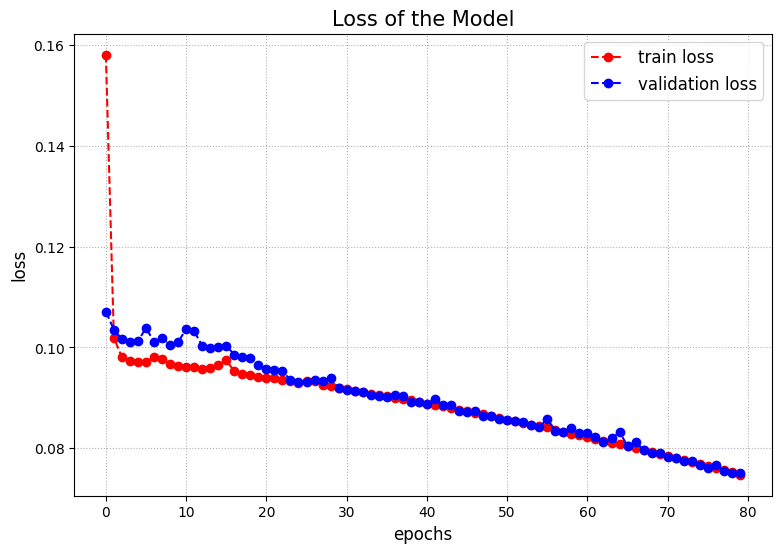

In [9]:
plot_history(history_sdss['loss'], history_sdss['val_loss'],
             'loss', save_as=f'loss-of-model_time={str_time}')

Train MAE: 0.681%
Validation MAE: 2.29%


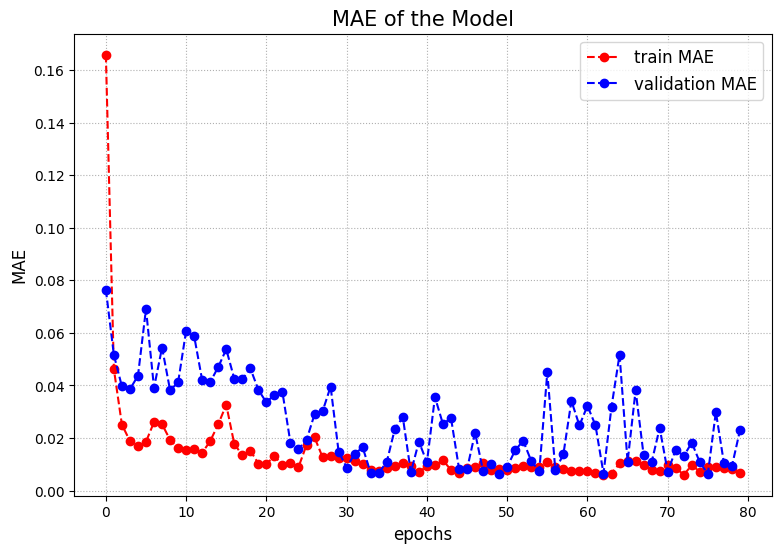

In [10]:
plot_history(history_sdss['mean_absolute_error'], history_sdss['val_mean_absolute_error'],
             'MAE', save_as=f'mae-of-model_time={str_time}')

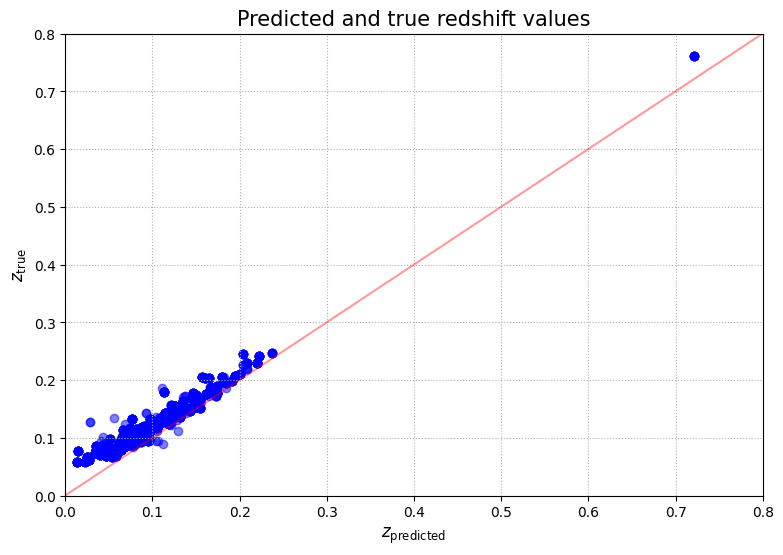

In [11]:
plot_predicted_vs_true_values(predict_sdss, validation_set_features,
                              save_as=f'pred-vs-true-values_time={str_time}')

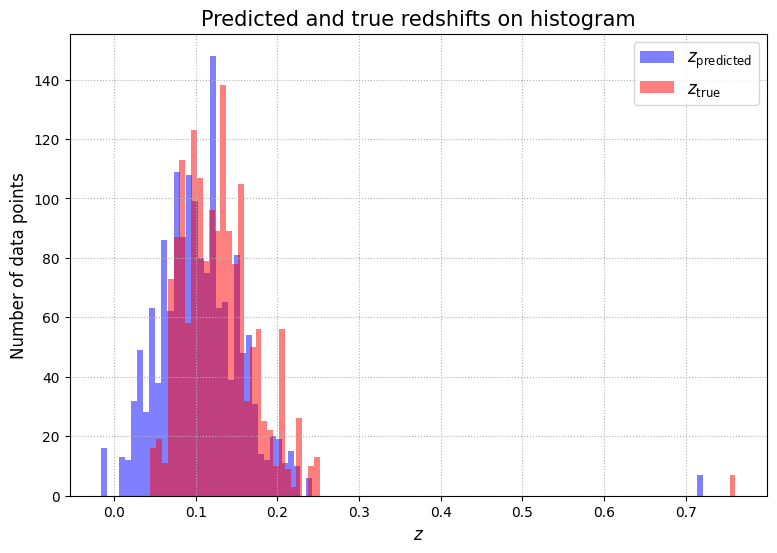

In [12]:
plot_predicted_vs_true_histogram(predict_sdss, validation_set_features,
                              save_as=f'pred-vs-true-histogram_time={str_time}')

---
### Create flowchart about the CNN model

To use `tf.keras.utils.plot_model()` `pydot` and `graphviz` are required.
```python
%%bash
pip install pydot
pip install graphviz
```

Create figures about the architecture of the CNN.
```python
layer_names = [layer.name for layer in model_sdss.layers]
layer_ranges = [layer_names[0], layer_names[7],
          layer_names[8], layer_names[14],
          layer_names[15], layer_names[24],
          layer_names[25], layer_names[34],
          layer_names[35], layer_names[44]]

for i in range(5):
    tf.keras.utils.plot_model(model_sdss, 
                              to_file=f"figures/model-sdss_block-{i+1}.pdf", 
                              show_shapes=True,
                              dpi=40,
                              layer_range=[layer_ranges[2*i], layer_ranges[2*i+1]],
                              show_layer_activations=True,
                             )
```